## IMPORTS

In [15]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option("display.max_columns", None)

## LOAD DATA

In [16]:
try:
    df = pd.read_csv("bank_transactions_data_2.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'bank_transactions_data_2.csv' not found. Please upload the file.")

if 'df' in locals():
    print("="*70)
    print("DATASET OVERVIEW")
    print("="*70)
    print(df.head())
    print()
    print(df.info())

    # Summary statistics for numeric columns
    print("\nBasic numeric summary:")
    print(df[["TransactionAmount", "CustomerAge",
              "TransactionDuration", "LoginAttempts",
              "AccountBalance"]].describe())


Dataset loaded successfully.
DATASET OVERVIEW
  TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0        

## DATA QUALITY CHECKS

In [17]:


# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Remove duplicates
print("\nDuplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()



Missing values per column:
TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64

Duplicate rows: 0


## EDA

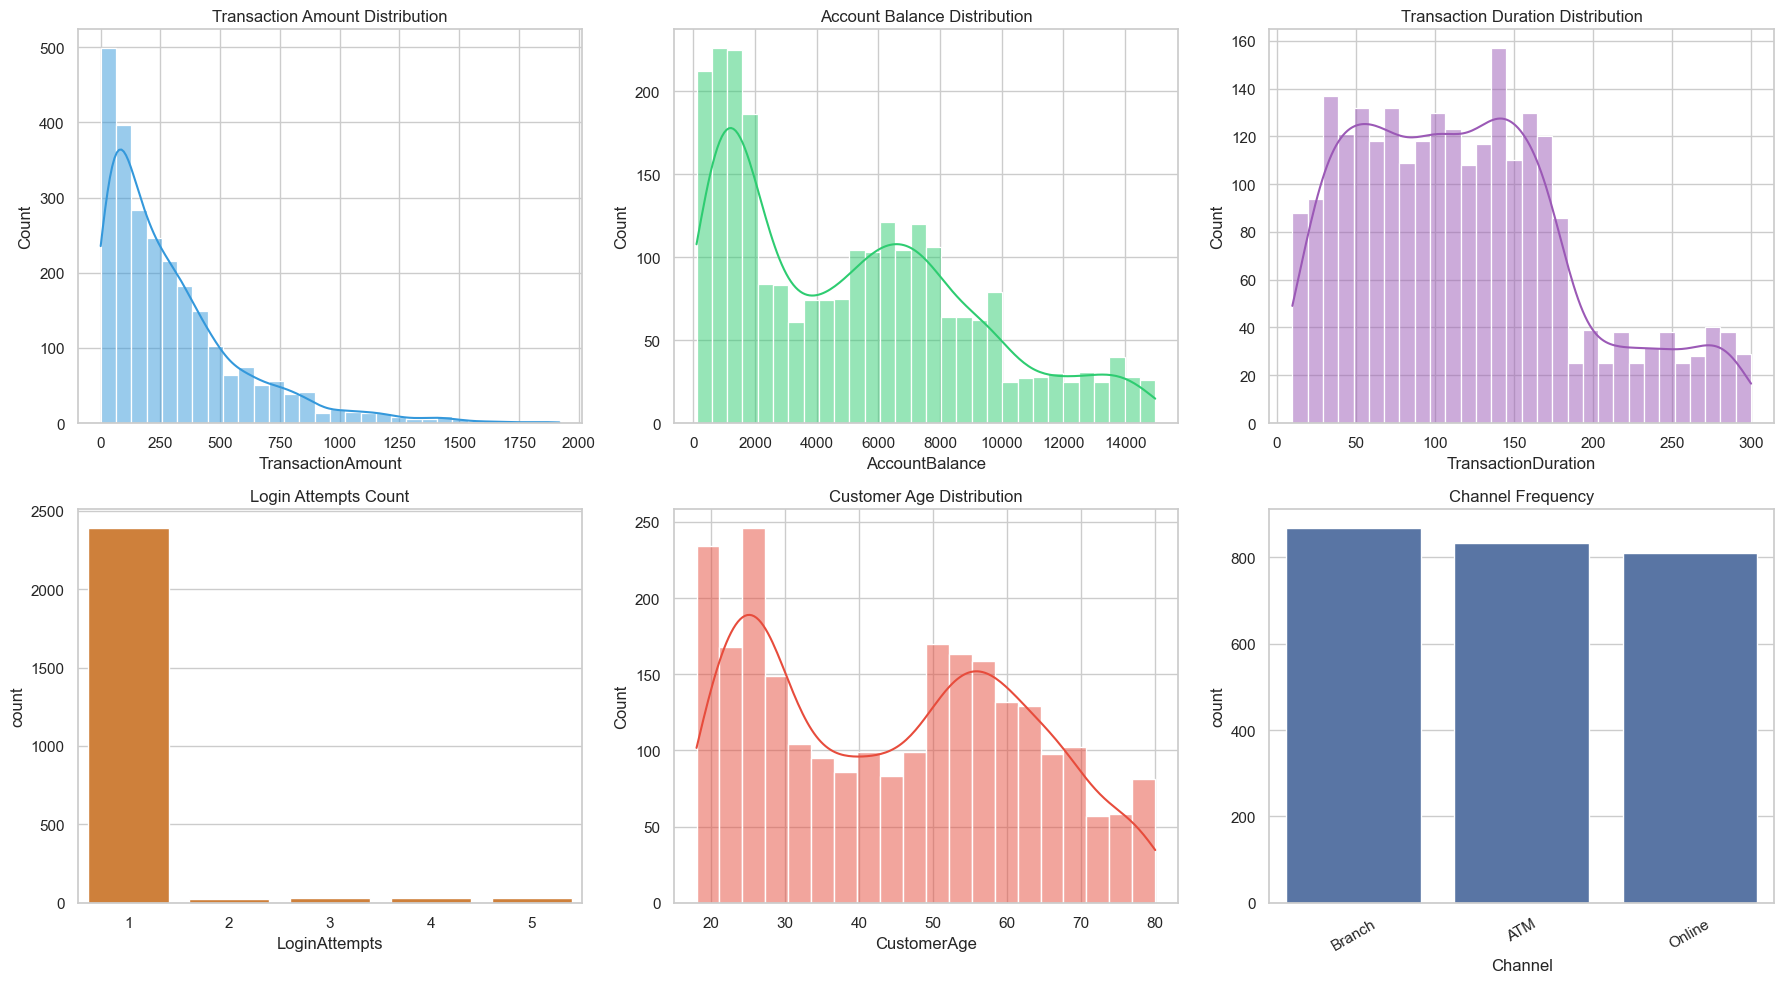

In [18]:
# Create 6-panel visualization dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

# Panel 1: Transaction Amount distribution
sns.histplot(df["TransactionAmount"], bins=30, ax=axes[0], kde=True, color="#3498db")
axes[0].set_title("Transaction Amount Distribution")

# Panel 2: Account Balance distribution
sns.histplot(df["AccountBalance"], bins=30, ax=axes[1], kde=True, color="#2ecc71")
axes[1].set_title("Account Balance Distribution")

# Panel 3: Transaction Duration distribution
sns.histplot(df["TransactionDuration"], bins=30, ax=axes[2], kde=True, color="#9b59b6")
axes[2].set_title("Transaction Duration Distribution")

# Panel 4: Login Attempts frequency (often all 1s—anomalies show 2-5)
sns.countplot(x="LoginAttempts", data=df, ax=axes[3], color="#e67e22")
axes[3].set_title("Login Attempts Count")

# Panel 5: Customer Age distribution (often bimodal)
sns.histplot(df["CustomerAge"], bins=20, ax=axes[4], kde=True, color="#e74c3c")
axes[4].set_title("Customer Age Distribution")

# Panel 6: Channel frequency (Branch, ATM, Online)
sns.countplot(x="Channel", data=df, ax=axes[5], order=df["Channel"].value_counts().index)
axes[5].set_title("Channel Frequency")
axes[5].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()


## FEATURE SELECTION & PREPROCESSING

In [19]:
# Drop ID columns and date-like identifiers
id_cols = ["TransactionID", "AccountID", "IP Address", "PreviousTransactionDate"]
date_cols = ["TransactionDate"]

# Select all columns except identifiers
feature_cols = [c for c in df.columns if c not in id_cols]
X = df[feature_cols].copy()

# Separate numeric and categorical features
numeric_features = ["TransactionAmount", "CustomerAge",
                    "TransactionDuration", "LoginAttempts",
                    "AccountBalance"]

categorical_features = [c for c in X.columns if c not in numeric_features]

# Build preprocessing pipeline:
#   - Standardize numeric features
#   - One-hot encode categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


## ISOLATION FOREST ANOMALY DETECTION

In [20]:
iso_forest = IsolationForest(
    n_estimators=300,
    contamination=0.02,
    random_state=42,
    n_jobs=-1
)

iso_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", iso_forest),
])


iso_pipeline.fit(X)


Xtrans = iso_pipeline["preprocess"].transform(X)
labels_iso = iso_pipeline["model"].predict(Xtrans)
scores_iso = -iso_pipeline["model"].score_samples(Xtrans)  

# Store results in DataFrame
df["IF_AnomalyLabel"] = (labels_iso == -1).astype(int)  
df["IF_AnomalyScore"] = scores_iso

print(f"Isolation Forest flagged {df['IF_AnomalyLabel'].sum()} anomalies "
      f"out of {len(df)} transactions "
      f"({100*df['IF_AnomalyLabel'].mean():.2f}%)")


Isolation Forest flagged 51 anomalies out of 2512 transactions (2.03%)


## LOCAL OUTLIER FACTOR (LOF) ANOMALY DETECTION

In [21]:
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.02,
    novelty=False  
)


lof_labels = lof.fit_predict(Xtrans)
lof_scores = -lof.negative_outlier_factor_

df["LOF_AnomalyLabel"] = (lof_labels == -1).astype(int)
df["LOF_AnomalyScore"] = lof_scores

print(f"LOF flagged {df['LOF_AnomalyLabel'].sum()} anomalies "
      f"out of {len(df)} transactions "
      f"({100*df['LOF_AnomalyLabel'].mean():.2f}%)")


LOF flagged 51 anomalies out of 2512 transactions (2.03%)


## COMPARE ISOLATION FOREST & LOF

In [22]:
print("\n" + "="*70)
print("COMPARING ISOLATION FOREST AND LOF")
print("="*70)

# Find transactions flagged by BOTH models
both_flagged = ((df["IF_AnomalyLabel"] == 1) & (df["LOF_AnomalyLabel"] == 1)).sum()
print(f"\nTransactions flagged by BOTH models: {both_flagged}")

# Display top 10 most anomalous transactions (ranked by Isolation Forest score)
top_anomalies = df.nlargest(10, "IF_AnomalyScore")
print("\nTop 10 most anomalous transactions (Isolation Forest):")
print(top_anomalies[["TransactionID", "TransactionAmount", "CustomerAge", 
                      "TransactionDuration", "LoginAttempts", "AccountBalance",
                      "IF_AnomalyScore", "LOF_AnomalyScore"]])



COMPARING ISOLATION FOREST AND LOF

Transactions flagged by BOTH models: 2

Top 10 most anomalous transactions (Isolation Forest):
     TransactionID  TransactionAmount  CustomerAge  TransactionDuration  \
1142      TX001143             568.88           19                  105   
1703      TX001704            1294.81           45                  279   
1972      TX001973            1087.90           78                  103   
2140      TX002141             519.62           71                   40   
1226      TX001227             775.60           79                  158   
2217      TX002218             275.98           72                   67   
1052      TX001053             168.00           32                   11   
1897      TX001898             702.87           19                  184   
1362      TX001363              54.85           58                   40   
2132      TX002133             341.88           43                   89   

      LoginAttempts  AccountBalance  IF_An

## ANOMALY SCORES VISUALIZATION

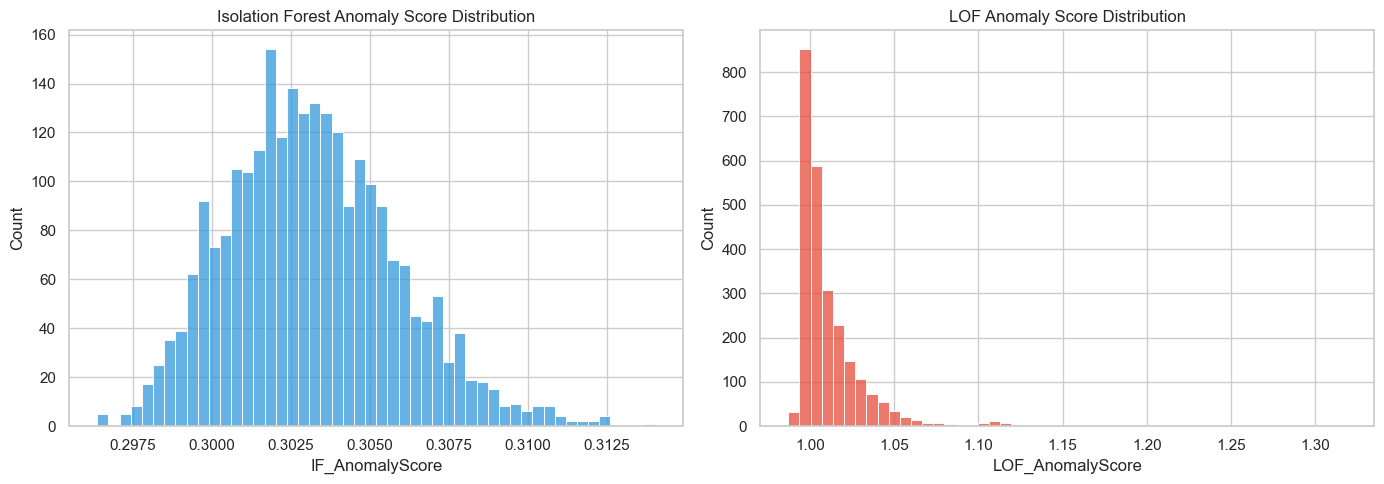

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Isolation Forest scores
sns.histplot(df["IF_AnomalyScore"], bins=50, ax=axes[0], color="#3498db")
axes[0].set_title("Isolation Forest Anomaly Score Distribution")
axes[0].set_xlabel("IF_AnomalyScore")

# Right: LOF scores
sns.histplot(df["LOF_AnomalyScore"], bins=50, ax=axes[1], color="#e74c3c")
axes[1].set_title("LOF Anomaly Score Distribution")
axes[1].set_xlabel("LOF_AnomalyScore")

plt.tight_layout()
plt.show()


## SUMMARY STATISTICS

In [24]:
print("\n" + "="*70)
print("ANOMALY DETECTION SUMMARY")
print("="*70)
print(f"Total transactions analyzed: {len(df)}")
print(f"Isolation Forest anomalies: {df['IF_AnomalyLabel'].sum()}")
print(f"LOF anomalies: {df['LOF_AnomalyLabel'].sum()}")
print(f"Consensus anomalies (both models agree): {both_flagged}")
print(f"Average Isolation Forest score: {df['IF_AnomalyScore'].mean():.4f}")
print(f"Average LOF score: {df['LOF_AnomalyScore'].mean():.4f}")


ANOMALY DETECTION SUMMARY
Total transactions analyzed: 2512
Isolation Forest anomalies: 51
LOF anomalies: 51
Consensus anomalies (both models agree): 2
Average Isolation Forest score: 0.3032
Average LOF score: 1.0115
